In [6]:
!pip install ISLP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from ISLP.models import ModelSpec as MS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from ISLP.models import sklearn_sm
import statsmodels.api as sm
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from pygam import (s as s_gam, LinearGAM)
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

np.random.seed(55)
df = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)
Y = df['Rings']
features = df.drop(columns=['Rings','id']).columns.tolist()
X_train = df[features].values
gam = LinearGAM(s_gam(0))
lams = np.logspace(-2, 6, 5)
gam = gam.gridsearch(X_train, Y, lam=lams)
print(f'Optimum lambda: {gam.lam[0][0]:.2f}')
gam.fit(X_train, Y)
y_pred = gam.predict(X_train)
y_pred = np.maximum(0, y_pred)
residuals = Y - y_pred

100% (5 of 5) |##########################| Elapsed Time: 0:00:01 Time:  0:00:010:00


Optimum lambda: 1.00


## Check Assumptions

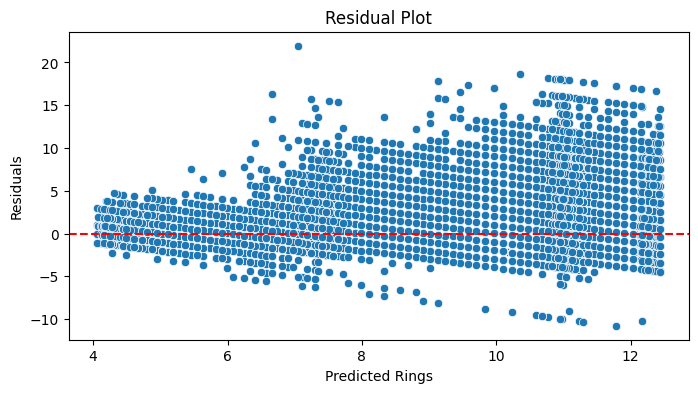

In [7]:
# Residual plot
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Rings')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

Scatter pattern around the red line rejects linearity, and funnel shape rejects constant spread (homoscedasticity).

In [8]:
dw = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw:.2f}')

Durbin-Watson statistic: 1.99


DW ≈ 2 → no autocorrelation.

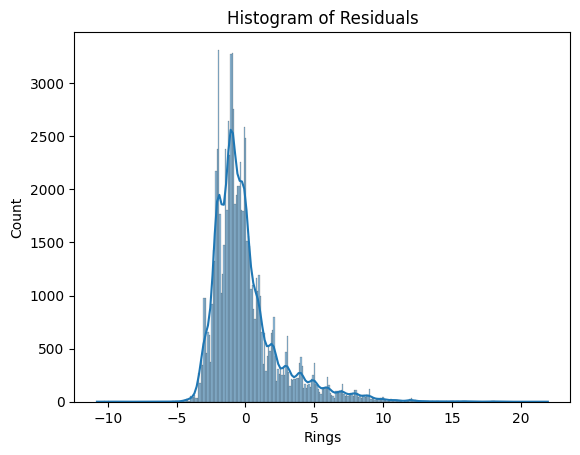

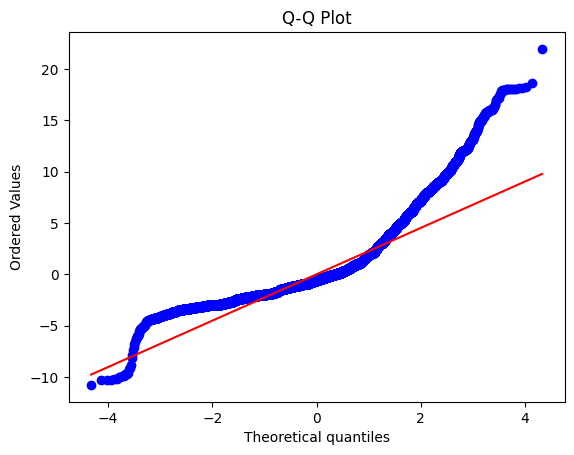

In [9]:
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.show()

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

Not all points fall on 45 degree red line, the normality assumption does not hold up.

In [12]:
# Check VIFs
vif_data = pd.DataFrame()
design = MS(df.columns.drop(['Rings', 'id'])).fit(df)
D = design.fit_transform(df)
X = np.asarray(D)
vif_data["feature"] = D.columns
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print(vif_data)

          feature        VIF
0       intercept  84.084459
1          Length  51.208712
2        Diameter  54.291324
3          Height   7.813579
4    Whole weight  69.242348
5  Whole weight.1  21.463228
6  Whole weight.2  20.067845
7    Shell weight  18.339175
8           Sex_I   2.387746
9           Sex_M   1.442002


VIF > 5 → moderate multicollinearity.  
VIF > 10 → severe multicollinearity.

In [14]:
# --- Load test data ---
test_df = pd.read_csv("/kaggle/input/playground-series-s4e4/test.csv")
test_ids = test_df["id"]
test_df = pd.get_dummies(test_df, columns=['Sex'], drop_first=True)
design2 = MS(test_df.columns.drop('id')).fit(test_df)
D2 = design2.fit_transform(test_df)
D2 = D2.drop('intercept', axis=1)
X_test = np.asarray(D2)
# --- Predict using Model ---
preds = gam.predict(X_test)
preds = np.maximum(0, preds)

# --- Save submission files ---
submission = pd.DataFrame({'id': test_ids, 'Rings': preds})
submission.to_csv("submission_model.csv", index=False)
print("Submissions saved: submission_model.csv")

Submissions saved: submission_model.csv
